In [30]:
import os, sys
sys.version

'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [31]:
print(f"a = {1+1}")

a = 2


In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
size = 3
step = 2
A = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
A = [A[i : i + size] for i in range(0, len(A), step)]

In [4]:
def get_sliding_windows(array, size=3, step=2):
    return [array[i : i + size] for i in range(0, len(array), step)]

In [5]:
A = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
get_sliding_windows(A, 10)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [3, 4, 5, 6, 7, 8, 9, 10],
 [5, 6, 7, 8, 9, 10],
 [7, 8, 9, 10],
 [9, 10]]

In [6]:
import wave
import numpy
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, rfft
from scipy.interpolate import interp1d
from scipy.signal      import argrelextrema
import glob, os, sys
import scipy.signal as sg
from scipy import signal
from scipy.signal import minimum_phase
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import random

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Text(0, 0.5, 'Amplitude')

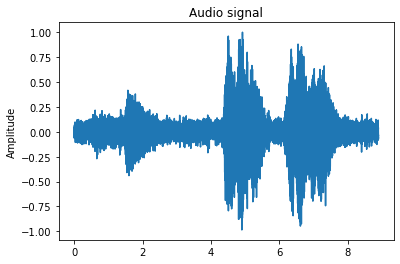

In [9]:
ifile = wave.open("/content/drive/My Drive/experiments_AURA/audio_010.wav")
samples = 2*ifile.getnframes()
frequency = ifile.getframerate()
audio = ifile.readframes(samples)

# Convert buffer to float32 using NumPy                                                                                 
audio_as_np_int16 = numpy.frombuffer(audio, dtype=numpy.int16)
audio_as_np_float32 = audio_as_np_int16.astype(numpy.float32)

# Normalise float32 array so that values are between -1.0 and +1.0                                                      
max_int16 = 2**15

time = [i/frequency for i in range(samples)]
audio_normalised = audio_as_np_float32 / max_int16
audio_normalised = audio_normalised / max(audio_normalised)
#sos = signal.butter(30, 100, 'hp', fs=frequency, output='sos')
#audio_normalised = signal.sosfilt(sos, audio_normalised)

plt.plot(time, audio_normalised)
plt.title('Audio signal')
plt.ylabel('Amplitude')


In [10]:
#https://stackoverflow.com/questions/34235530/python-how-to-get-high-and-low-envelope-of-a-signal
def hl_envelopes_idx(s,dmin=3,dmax=4):
    """
    Input :
    s : 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax : int, size of chunks, use this if size of data is too big
    Output :
    lmin,lmax : high/low enveloppe idx of signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    
    """# using the following might help in some case by cutting the signal in "half"
    s_mid = np.mean(s)
    # pre-sorting of locals min based on sign 
    lmin = lmin[s[lmin]<s_mid]
    # pre-sorting of local max based on sign 
    lmax = lmax[s[lmax]>s_mid]"""
    

    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

def autocorrellation(x):
    result = sg.correlate(x, x, mode='full', method="fft")
    return result

def real_dft(x):
    return np.fft.rfft(x)

Text(0, 0.5, 'Amplitude')

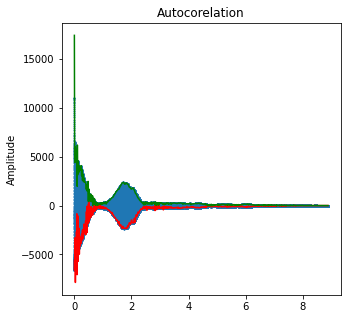

In [11]:
plt.rcParams["figure.figsize"] = (5,5)

a = autocorrellation(audio_normalised)

a = (a[len(a)//2:])
"""analytic_signal = hilbert(a)
amplitude_envelope = np.abs(analytic_signal)"""

#f2 = interp1d(time[:len(a)], amplitude_envelope, kind='cubic')
#peaks, _ = find_peaks(amplitude_envelope, prominence=1)
"""analytic_signal = hilbert(amplitude_envelope)
amplitude_envelope = np.abs(analytic_signal)"""

low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")

plt.scatter(time[:len(a)], a, s=1)

plt.plot(np.array(time), low_enveloppe(time), label='nearest', color='red')
plt.plot(np.array(time), high_enveloppe(time), label='nearest', color='green')
#plt.plot(np.array(time), high_enveloppe(time)-low_enveloppe(time), label='nearest', color='black')

#plt.plot(time[:len(a)], f2(time[:len(a)]), label='envelope', color='red')
#plt.plot(np.array(time[:len(a)]), amplitude_envelope, color="orange")
plt.title('Autocorelation')
plt.ylabel('Amplitude')


Text(0, 0.5, 'Amplitude')

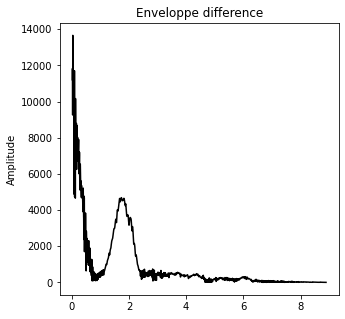

In [12]:
plt.plot(np.array(time)[1000:], (high_enveloppe(time)-low_enveloppe(time))[1000:], label='nearest', color='black')
plt.title('Enveloppe difference')
plt.ylabel('Amplitude')


In [13]:
[f"/content/drive/My Drive/experiments_AURA/audio_{i:03d}.wav" for i in range(2, 12)]


['/content/drive/My Drive/experiments_AURA/audio_002.wav',
 '/content/drive/My Drive/experiments_AURA/audio_003.wav',
 '/content/drive/My Drive/experiments_AURA/audio_004.wav',
 '/content/drive/My Drive/experiments_AURA/audio_005.wav',
 '/content/drive/My Drive/experiments_AURA/audio_006.wav',
 '/content/drive/My Drive/experiments_AURA/audio_007.wav',
 '/content/drive/My Drive/experiments_AURA/audio_008.wav',
 '/content/drive/My Drive/experiments_AURA/audio_009.wav',
 '/content/drive/My Drive/experiments_AURA/audio_010.wav',
 '/content/drive/My Drive/experiments_AURA/audio_011.wav']

In [25]:
count = []

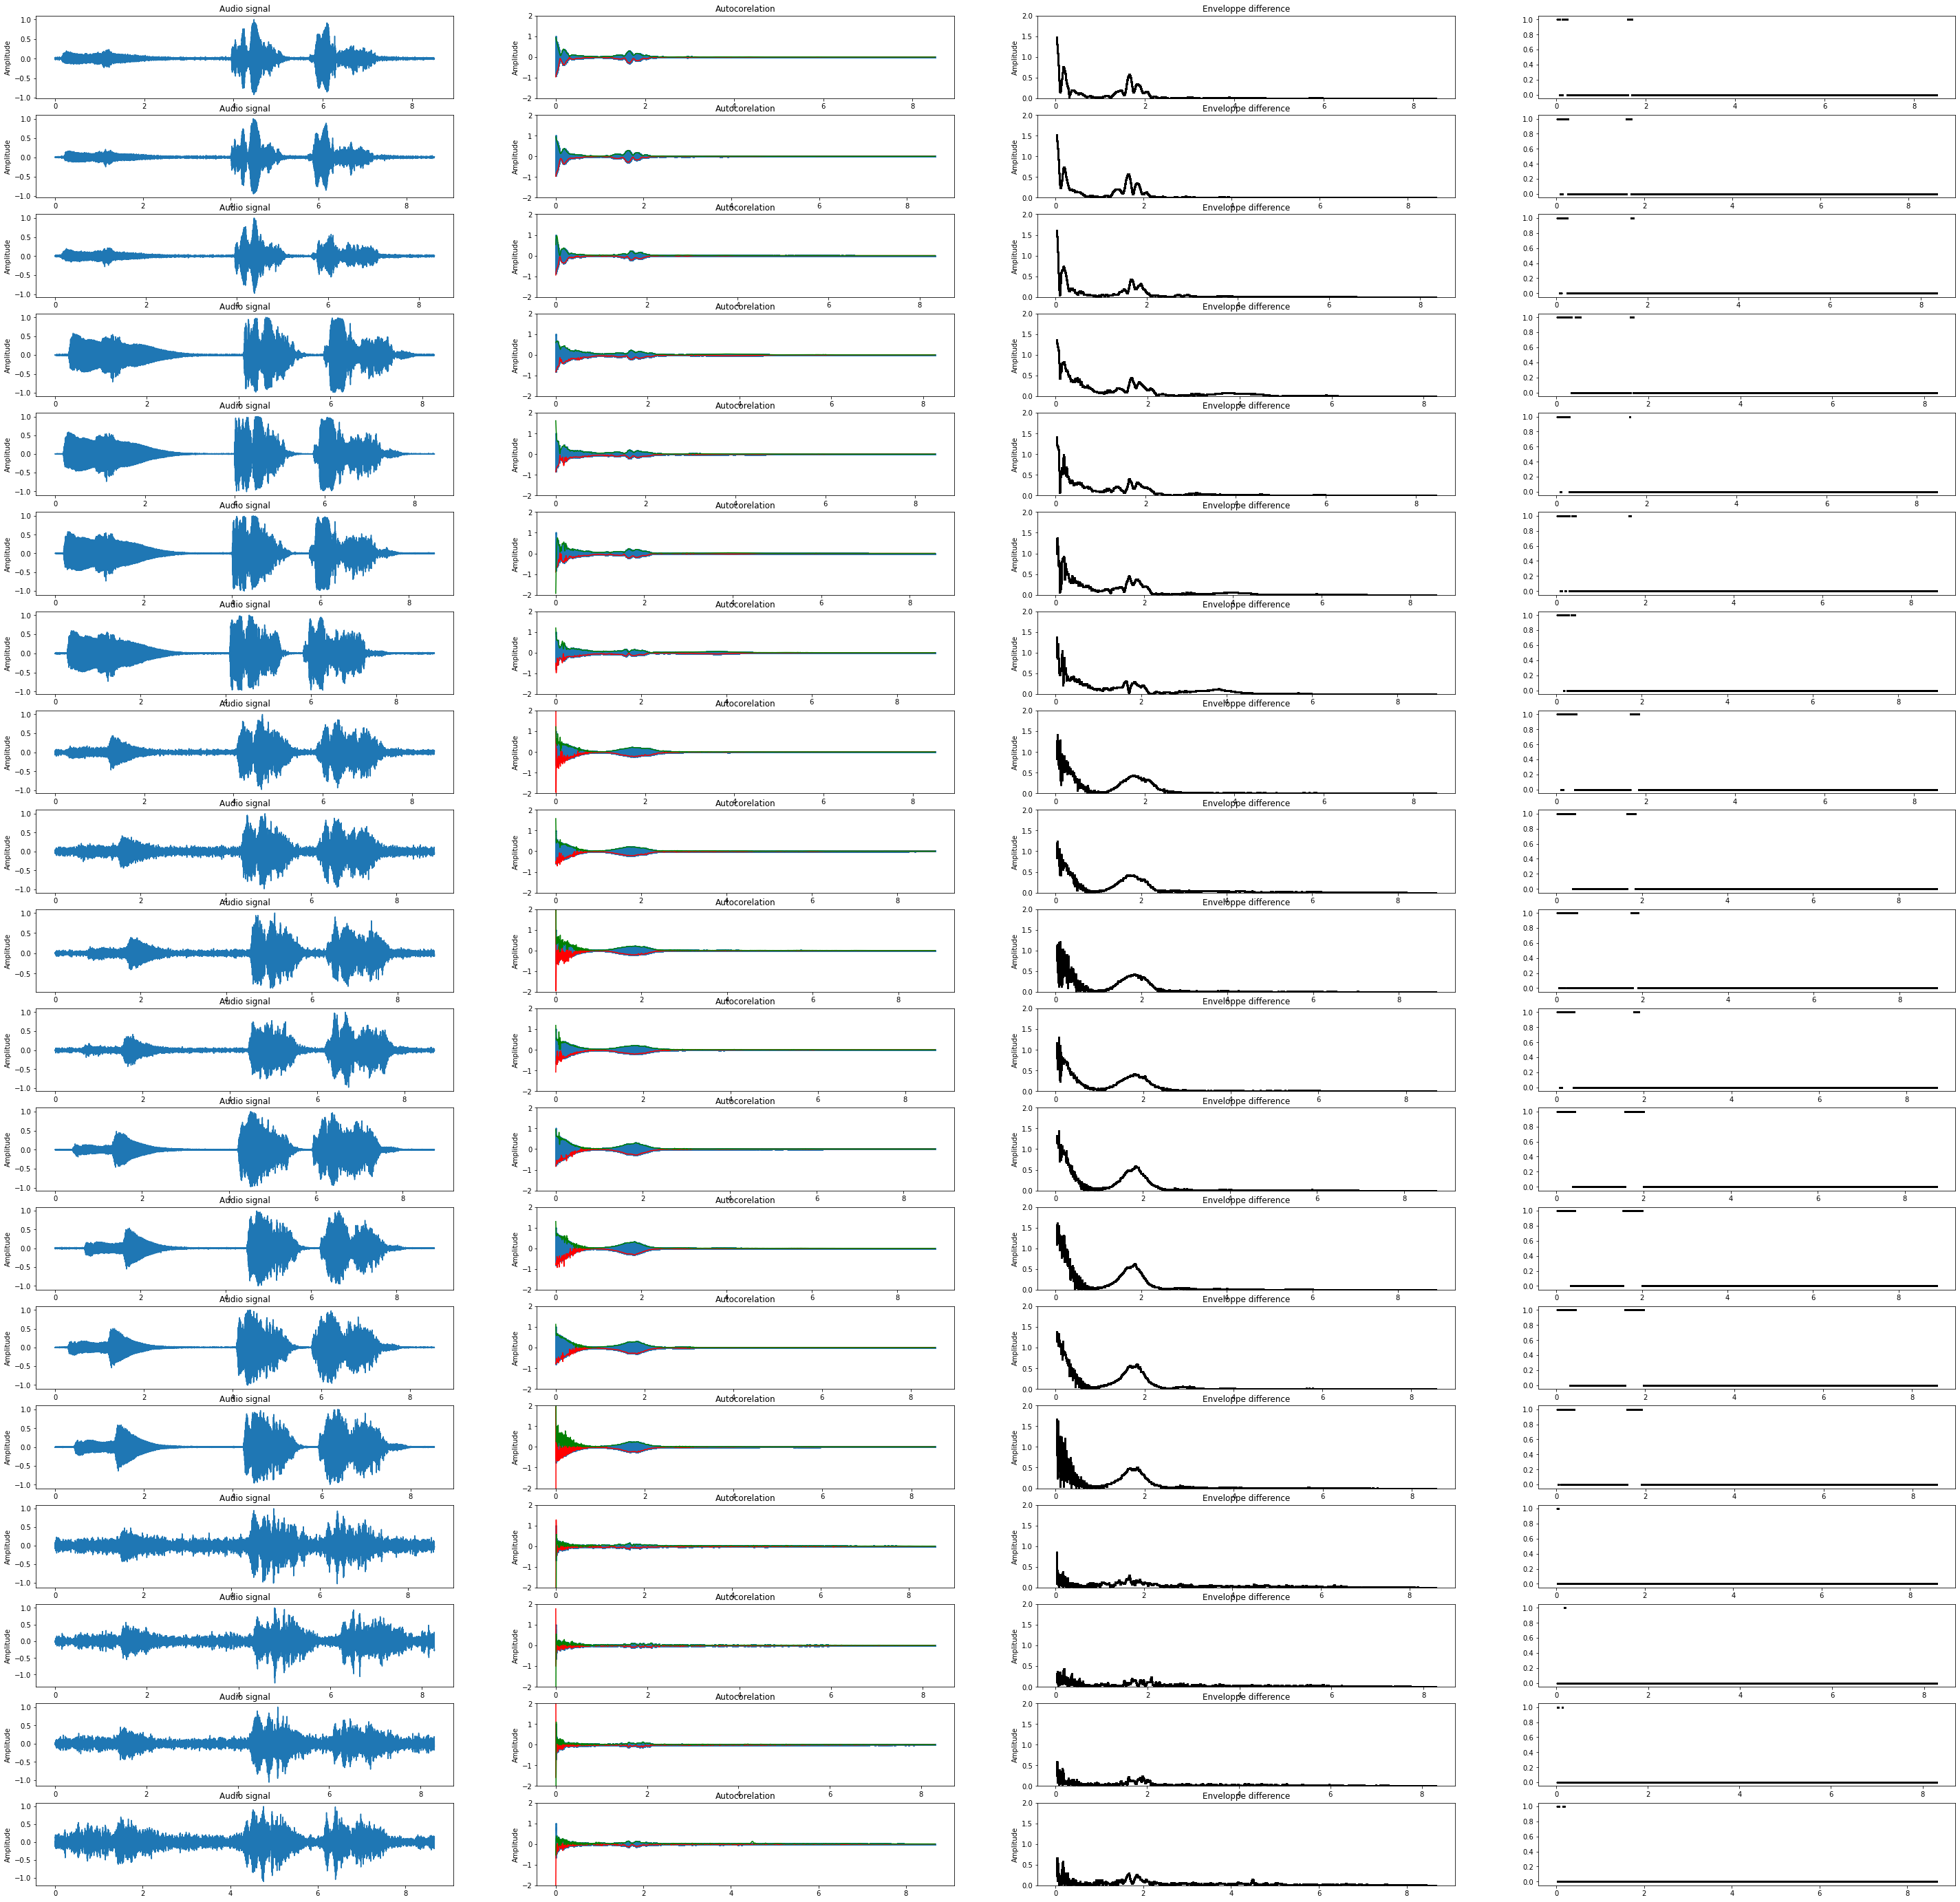

In [26]:
plt.rcParams["figure.figsize"] = (50,50)

files = [f"/content/drive/My Drive/experiments_AURA/audio_{i:03d}.wav" for i in range(2, 21)]

for i in range(len(files)):
  ifile = wave.open(files[i])
  samples = 2*ifile.getnframes()
  frequency = ifile.getframerate()
  audio = ifile.readframes(samples)

  # Convert buffer to float32 using NumPy                                                                                 
  audio_as_np_int16 = numpy.frombuffer(audio, dtype=numpy.int16)
  audio_as_np_float32 = audio_as_np_int16.astype(numpy.float32)

  # Normalise float32 array so that values are between -1.0 and +1.0                                                      
  max_int16 = 2**15

  time = [i/frequency for i in range(samples)]
  audio_normalised = audio_as_np_float32 / max_int16
  audio_normalised = audio_normalised / max(audio_normalised)
  sos = signal.butter(30, 100, 'hp', fs=frequency, output='sos')
  #audio_normalised = signal.sosfilt(sos, audio_normalised)

  plt.subplot(len(files), 4, 4*i+1)
  plt.plot(time, audio_normalised)
  plt.title('Audio signal')
  plt.ylabel('Amplitude')


  a = autocorrellation(audio_normalised)

  a = a[len(a)//2:]
  """analytic_signal = hilbert(a)
  amplitude_envelope = np.abs(analytic_signal)"""

  #f2 = interp1d(time[:len(a)], amplitude_envelope, kind='cubic')
  #peaks, _ = find_peaks(amplitude_envelope, prominence=1)
  """analytic_signal = hilbert(amplitude_envelope)
  amplitude_envelope = np.abs(analytic_signal)"""

  a = a / a[0]
  low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
  low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
  high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")

  plt.subplot(len(files), 4, 4*i+2)
  plt.ylim((-2,2))
  plt.scatter(time[:len(a)], a, s=1)
  plt.plot(np.array(time), low_enveloppe(time), label='nearest', color='red')
  plt.plot(np.array(time), high_enveloppe(time), label='nearest', color='green')
  
  #plt.plot(np.array(time), high_enveloppe(time)-low_enveloppe(time), label='nearest', color='black')

  #plt.plot(time[:len(a)], f2(time[:len(a)]), label='envelope', color='red')
  #plt.plot(np.array(time[:len(a)]), amplitude_envelope, color="orange")
  plt.title('Autocorelation')
  plt.ylabel('Amplitude')

  plt.subplot(len(files), 4, 4*i+3)
  plt.scatter(np.array(time)[1000:], (high_enveloppe(time)-low_enveloppe(time))[1000:], label='nearest', color='black', s=1)
  plt.title('Enveloppe difference')
  plt.ylabel('Amplitude')
  plt.ylim((0,2))

  def threshold(array, limit=0.4):
    a = np.array(array, copy=True)  
    a[a >= limit] = 1
    a[a <  limit] = 0
    return a

  b = threshold((high_enveloppe(time)-low_enveloppe(time))[1000:])
  count.append(np.count_nonzero(b))
  plt.subplot(len(files), 4, 4*i+4)
  plt.scatter(np.array(time)[1000:], b , label='nearest', color='black', s=1)


In [28]:
np.array(count) > 5000

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False])

In [82]:
thresholds = list(set([5*i/100 for i in range(21)] + [i/100 for i in range(25, 60)]))
thresholds.sort()
truth = np.array([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False])

In [84]:
def threshold(array, limit):
  a = np.array(array, copy=True)  
  a[a >= limit] = 1
  a[a <  limit] = 0
  return a

y = []
fp = []
tp = []

for thresh in thresholds:
  files = [f"/content/drive/My Drive/experiments_AURA/audio_{i:03d}.wav" for i in range(2, 21)]
  prediction = []
  for i in range(len(files)):
    ifile = wave.open(files[i])
    samples = 2*ifile.getnframes()
    frequency = ifile.getframerate()
    audio = ifile.readframes(samples)

    # Convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = numpy.frombuffer(audio, dtype=numpy.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(numpy.float32)

    # Normalise float32 array so that values are between -1.0 and +1.0                                                      
    max_int16 = 2**15

    time = [i/frequency for i in range(samples)]
    audio_normalised = audio_as_np_float32 / max_int16
    audio_normalised = audio_normalised / max(audio_normalised)
    a = autocorrellation(audio_normalised)

    a = a[len(a)//2:]
    a = a / a[0]

    low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
    low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
    high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")

    b = threshold((high_enveloppe(time)-low_enveloppe(time))[1000:], thresh)
    count = np.count_nonzero(b)
    prediction.append(count > 5000)

  tn_v, fp_v, fn_v, tp_v = confusion_matrix(truth, np.array(prediction)).ravel()
  fp.append(fp_v)
  tp.append(tp_v)
  """c = np.array(prediction) == truth
  y.append(np.count_nonzero(c)/len(c))"""



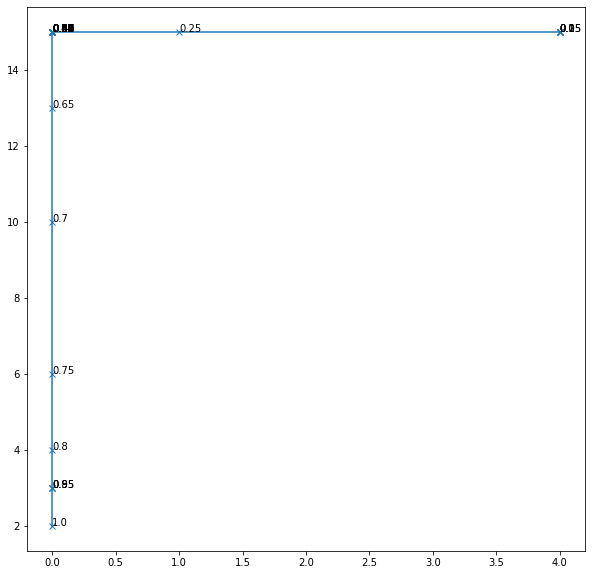

In [87]:
plt.rcParams["figure.figsize"] = (10,10)

z=np.array(fp)
y=np.array(tp)
plt.plot(z, y, marker="x")
for i, txt in enumerate(thresholds):
    plt.annotate(txt, (z[i], y[i]))
plt.show()

In [74]:
fp

[4,
 4,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Sliding window

In [ ]:
audio_normalised.shape

In [ ]:
WINDOW_SIZE = 408258//8
WINDOW_STRIDE = 408258//12


In [ ]:
windows = [a for a in get_sliding_windows(audio_normalised, WINDOW_SIZE, WINDOW_STRIDE) if len(a)==WINDOW_SIZE]

In [ ]:
len(windows)

In [ ]:
seq = random.choice(windows)

In [ ]:
seq.shape

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)

for i in range(len(windows)):
  a = autocorrellation(windows[i])

  a = a[len(a)//2:]
  """analytic_signal = hilbert(a)
  amplitude_envelope = np.abs(analytic_signal)"""

  #f2 = interp1d(time[:len(a)], amplitude_envelope, kind='cubic')
  #peaks, _ = find_peaks(amplitude_envelope, prominence=1)
  """analytic_signal = hilbert(amplitude_envelope)
  amplitude_envelope = np.abs(analytic_signal)"""

  low_enveloppe, high_enveloppe = hl_envelopes_idx(a)
  low_enveloppe = interp1d(np.array(time)[low_enveloppe], a[low_enveloppe], kind="cubic", fill_value="extrapolate")
  high_enveloppe = interp1d(np.array(time)[high_enveloppe], a[high_enveloppe], kind="cubic", fill_value="extrapolate")
  plt.subplot(4, 4, i+1)
  plt.scatter(time[:len(a)], a, s=1)

  #plt.plot(np.array(time), low_enveloppe(time), label='nearest', color='red')
  #plt.plot(np.array(time), high_enveloppe(time), label='nearest', color='green')

  #plt.plot(np.array(time), high_enveloppe(time)-low_enveloppe(time), label='nearest', color='black')

  #plt.plot(time[:len(a)], f2(time[:len(a)]), label='envelope', color='red')
  #plt.plot(np.array(time[:len(a)]), amplitude_envelope, color="orange")
  plt.title('Autocorelation')
  plt.ylabel('Amplitude')
